Training and Evaluation of BERT Model Starts from here


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd

# Correct path to your CSV file
csv_file_path = '/content/drive/My Drive/ner_datasetreferenc.csv'

# Try reading the CSV file with different encodings
df = None
encodings = ['utf-8', 'latin1', 'iso-8859-1']

for encoding in encodings:
    try:
        df = pd.read_csv(csv_file_path, encoding=encoding)
        print(f"Successfully read the file with encoding: {encoding}")
        break
    except UnicodeDecodeError as e:
        print(f"Failed to read the file with encoding {encoding}: {e}")

# Check if the dataframe was successfully created
if df is not None:
    # Display the first few rows of the dataframe
    print(df.head())
else:
    print("Failed to read the file with all tested encodings.")


Failed to read the file with encoding utf-8: 'utf-8' codec can't decode byte 0x85 in position 0: invalid start byte
Successfully read the file with encoding: latin1
    Sentence #           Word  POS Tag
0  Sentence: 1      Thousands  NNS   O
1          NaN             of   IN   O
2          NaN  demonstrators  NNS   O
3          NaN           have  VBP   O
4          NaN        marched  VBN   O


In [ ]:
# Preprocess the data
sentences = []
labels = []
sentence = []
label = []

for i in range(len(df)):
    word = df.loc[i, 'Word']
    tag = df.loc[i, 'Tag']

    if pd.notna(df.loc[i, 'Sentence #']):
        if sentence:
            sentences.append(sentence)
            labels.append(label)
            sentence = []
            label = []

    if pd.notna(word) and pd.notna(tag):  # Ensure no NaN values
        sentence.append(word)
        label.append(tag)

if sentence:
    sentences.append(sentence)
    labels.append(label)

print("Data preprocessed successfully.")
print(f"Number of sentences: {len(sentences)}")


Data preprocessed successfully.
Number of sentences: 47959


In [ ]:
!pip install transformers

import torch
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

input_ids = []
attention_masks = []
label_ids = []

label_map = {label: i for i, label in enumerate(set(df['Tag']))}

max_length = 64

for i in range(len(sentences)):
    # Ensure sentences[i] contains only valid strings
    if all(isinstance(word, str) for word in sentences[i]):
        encoded_dict = tokenizer.encode_plus(
                            sentences[i],
                            is_split_into_words=True,  # This line specifies that input is already split into words
                            add_special_tokens=True,
                            max_length=max_length,
                            pad_to_max_length=True,
                            truncation=True,
                            return_attention_mask=True,
                            return_tensors='pt',
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

        encoded_labels = [label_map[label] for label in labels[i]]
        # Truncate or pad the label sequence to match max_length
        encoded_labels = encoded_labels[:max_length] + [0] * (max_length - len(encoded_labels))
        label_ids.append(encoded_labels)

# Convert lists to tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
label_ids = torch.tensor(label_ids)

# Split into training and testing datasets (80/20 split)
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, label_ids, test_size=0.2, random_state=42)
train_masks, val_masks = train_test_split(attention_masks, test_size=0.2, random_state=42)

print("Tokenization, tensor preparation, and data splitting complete.")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Tokenization, tensor preparation, and data splitting complete.


In [ ]:
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler

# Create the DataLoader for training
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
val_dataset = TensorDataset(val_inputs, val_masks, val_labels)

train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=32)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=32)

print("DataLoaders created successfully.")


DataLoaders created successfully.


In [ ]:
from transformers import BertForTokenClassification

# Initialize the BERT model
model = BertForTokenClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(label_map),
    output_attentions=False,
output_hidden_states=False)

print("BERT model initialized successfully.")


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT model initialized successfully.


In [ ]:
from torch.optim import Adam

# Use Adam optimizer
optimizer = Adam(model.parameters(), lr=2e-5)

epochs = 3
early_stop_loss_threshold = 0.25

# Training loop with early stopping and loss printing every 100 steps
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    model.train()

    total_loss = 0
    avg_loss = 0

    for step, batch in enumerate(train_dataloader):
        batch_input_ids, batch_attention_mask, batch_labels = batch

        model.zero_grad()

        outputs = model(batch_input_ids,
                        token_type_ids=None,
                        attention_mask=batch_attention_mask,
                        labels=batch_labels)

        loss = outputs.loss
        total_loss += loss.item()
        avg_loss += loss.item()

        loss.backward()

        optimizer.step()

        if step % 100 == 99:  # Print average loss every 100 steps
            print(f'Step {step + 1}, Average Loss: {avg_loss / 100}')
            avg_loss = 0

    avg_train_loss = total_loss / len(train_dataloader)
    print(f'Average training loss for epoch {epoch + 1}: {avg_train_loss}')



print("Training complete!")


Epoch 1/3
Step 100, Average Loss: 0.5763221445679665
Step 200, Average Loss: 0.25370600789785386
Step 300, Average Loss: 0.19477234952151776
Step 400, Average Loss: 0.1574902357906103
Step 500, Average Loss: 0.13367656037211417
Step 600, Average Loss: 0.12149708323180676
Step 700, Average Loss: 0.10849409617483616
Step 800, Average Loss: 0.10746022365987301
Step 900, Average Loss: 0.09707665927708149
Step 1000, Average Loss: 0.09285198833793401
Step 1100, Average Loss: 0.08767365377396345
Average training loss for epoch 1: 0.16830171860002596
Early stopping as average training loss reached 0.16830171860002596
Training complete!


In [ ]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Function to convert predictions and labels to their respective tag names
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat, pred_flat)

def get_flat_labels(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return pred_flat, labels_flat

# Put model in evaluation mode
model.eval()

# Tracking variables
eval_loss, eval_accuracy = 0, 0
predictions, true_labels = [], []

# Evaluate data for one epoch
for batch in val_dataloader:
    batch_input_ids, batch_attention_mask, batch_labels = batch

    with torch.no_grad():
        outputs = model(batch_input_ids,
                        token_type_ids=None,
                        attention_mask=batch_attention_mask)

    logits = outputs.logits
    label_ids = batch_labels.to('cpu').numpy()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()

    predictions.append(logits)
    true_labels.append(label_ids)

# Calculate accuracy for the validation set
pred_flat, labels_flat = get_flat_labels(np.concatenate(predictions, axis=0), np.concatenate(true_labels, axis=0))

print("Accuracy: {:.2f}".format(flat_accuracy(np.concatenate(predictions, axis=0), np.concatenate(true_labels, axis=0)) * 100))

# Generate classification report
classification_rep = classification_report(labels_flat, pred_flat, target_names=[k for k, v in sorted(label_map.items(), key=lambda item: item[1])])
print(classification_rep)


Accuracy: 97.62


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       I-art       1.00      1.00      1.00    405023
       B-org       0.70      0.53      0.61      3913
       I-geo       0.65      0.64      0.65      1450
           O       0.97      0.97      0.97    176870
       I-org       0.58      0.65      0.62      3315
       B-tim       0.77      0.73      0.75      4048
       I-per       0.73      0.89      0.80      3445
       I-gpe       0.00      0.00      0.00        39
       I-tim       0.66      0.59      0.62      1300
       B-gpe       0.81      0.86      0.84      3175
       B-art       0.00      0.00      0.00        86
       B-per       0.77      0.75      0.76      3389
       B-nat       0.00      0.00      0.00        50
       B-geo       0.73      0.76      0.74      7664
       B-eve       0.00      0.00      0.00        59
       I-eve       0.00      0.00      0.00        50
       I-nat       0.00      0.00      0.00        12

    accuracy              

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


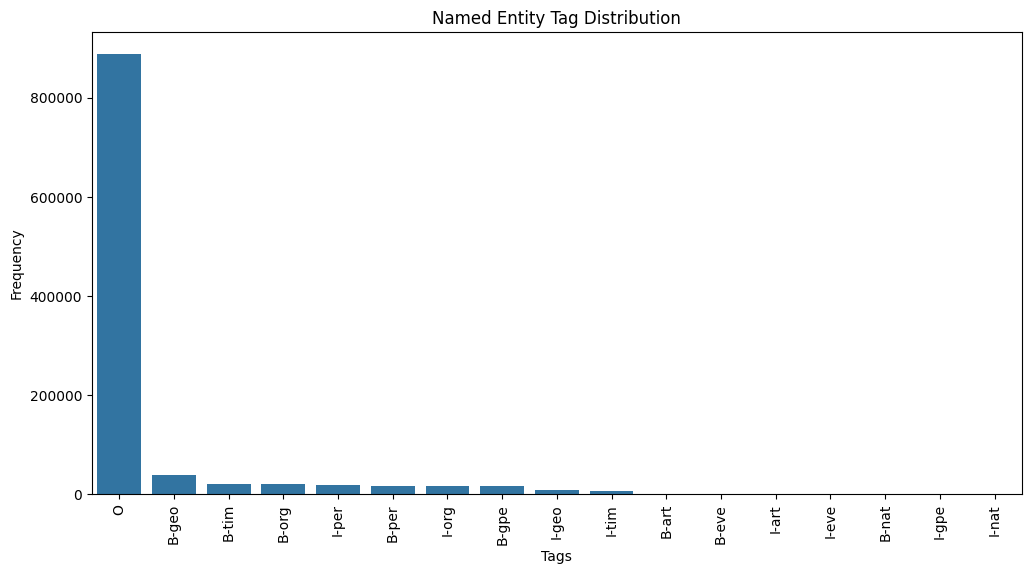

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the frequency of each tag
tag_counts = df['Tag'].value_counts()

# Plot the tag distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=tag_counts.index, y=tag_counts.values)
plt.title('Named Entity Tag Distribution')
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()


In [ ]:
pip install transformers  allennlp allennlp-models scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.2/730.2 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 464.5/464.5 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 75.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.2/248.2 kB 36.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 94.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 109.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 41.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
sentence_lengths = [len(sentence) for sentence in sentences]

plt.figure(figsize=(12, 6))
plt.hist(sentence_lengths, bins=50, color='c', edgecolor='k', alpha=0.7)
plt.title('Token Length Distribution')
plt.xlabel('Length of Sentences')
plt.ylabel('Number of Sentences')
plt.show()


In [ ]:
!pip install torch

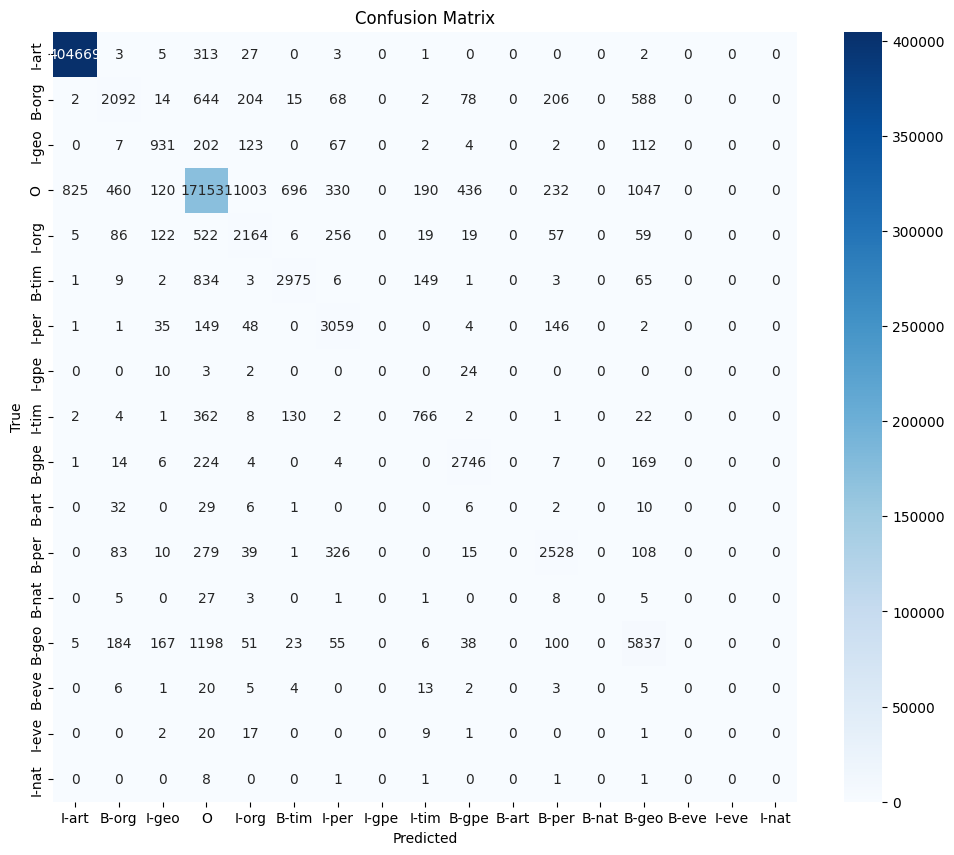

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

# Assuming you have `labels_flat` and `pred_flat` from the evaluation
cm = confusion_matrix(labels_flat, pred_flat)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[k for k, v in sorted(label_map.items(), key=lambda item: item[1])], yticklabels=[k for k, v in sorted(label_map.items(), key=lambda item: item[1])])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


BERT Ends here and Training and Evaluation of BERT + CRF Architecture starts from here


In [ ]:
import pandas as pd

# Correct path to your CSV file
csv_file_path = '/content/drive/My Drive/ner_datasetreferenc.csv'

# Try reading the CSV file with different encodings
df = None
encodings = ['utf-8', 'latin1', 'iso-8859-1']

for encoding in encodings:
    try:
        df = pd.read_csv(csv_file_path, encoding=encoding)
        print(f"Successfully read the file with encoding: {encoding}")
        break
    except UnicodeDecodeError as e:
        print(f"Failed to read the file with encoding {encoding}: {e}")

# Check if the dataframe was successfully created
if df is not None:
    # Display the first few rows of the dataframe
    print(df.head())
else:
    print("Failed to read the file with all tested encodings.")

Failed to read the file with encoding utf-8: 'utf-8' codec can't decode byte 0x85 in position 0: invalid start byte
Successfully read the file with encoding: latin1
    Sentence #           Word  POS Tag
0  Sentence: 1      Thousands  NNS   O
1          NaN             of   IN   O
2          NaN  demonstrators  NNS   O
3          NaN           have  VBP   O
4          NaN        marched  VBN   O


In [ ]:
from sklearn.model_selection import train_test_split
# Split dataframe into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Define a function to extract sentences grouped by 'Sentence #'
def get_sentences(data):
    agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(), s['POS'].values.tolist(), s['Tag'].values.tolist())]
    grouped = data.groupby('Sentence #').apply(agg_func)
    sentences = [s for s in grouped]
    return sentences

train_sentences = get_sentences(train_df)
test_sentences = get_sentences(test_df)

In [ ]:
from transformers import BertTokenizer
import torch

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def encode_sentences(sentences, tokenizer, max_len=128):
    input_ids = []
    attention_masks = []
    labels = []

    for sent in sentences:
        # Ensure all words are strings
        words = [str(w[0]) for w in sent]
        tags = [w[2] for w in sent]

        # Join words into a single string sentence
        sentence = " ".join(words)

        # Tokenize the sentence
        encodings = tokenizer(sentence, padding='max_length', truncation=True, max_length=max_len, return_tensors='pt')

        input_ids.append(encodings['input_ids'].squeeze(0))
        attention_masks.append(encodings['attention_mask'].squeeze(0))

        # Ensure the label list matches the tokenized input length
        label_ids = [tag2id[tag] for tag in tags] + [tag2id['O']] * (max_len - len(tags))
        labels.append(torch.tensor(label_ids).unsqueeze(0))

    input_ids = torch.stack(input_ids)
    attention_masks = torch.stack(attention_masks)
    labels = torch.cat(labels)

    return input_ids, attention_masks, labels

# Create a tag to id mapping
unique_tags = df['Tag'].unique()
tag2id = {tag: id for id, tag in enumerate(unique_tags)}
id2tag = {id: tag for tag, id in tag2id.items()}

train_input_ids, train_attention_masks, train_labels = encode_sentences(train_sentences, tokenizer)
test_input_ids, test_attention_masks, test_labels = encode_sentences(test_sentences, tokenizer)


In [ ]:
!pip install allennlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.2/730.2 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 70.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.2/248.2 kB 34.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 87.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 107.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 39.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 86.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11

In [ ]:
import torch
from torch import nn
from transformers import BertModel
from allennlp.modules.conditional_random_field import ConditionalRandomField

class BERT_CRF(nn.Module):
    def __init__(self, bert_model_name, num_labels):
        super(BERT_CRF, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
        self.crf = ConditionalRandomField(num_labels)

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        sequence_output = self.dropout(outputs[0])
        emissions = self.classifier(sequence_output)
        if labels is not None:
            log_likelihood = self.crf(emissions, labels, attention_mask)
            return -log_likelihood
        else:
            prediction = self.crf.viterbi_tags(emissions, attention_mask)
            return prediction


In [ ]:

import pandas as pd
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup

# Preprocess the data (assuming df is the DataFrame)
sentences = []
labels = []
sentence = []
label = []

for i in range(len(df)):
    word = df.loc[i, 'Word']
    tag = df.loc[i, 'Tag']

    if pd.notna(df.loc[i, 'Sentence #']):
        if sentence:
            sentences.append(sentence)
            labels.append(label)
            sentence = []
            label = []

    if pd.notna(word) and pd.notna(tag):
        sentence.append(word)
        label.append(tag)

if sentence:
    sentences.append(sentence)
    labels.append(label)

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

input_ids = []
attention_masks = []
label_ids = []

label_map = {label: i for i, label in enumerate(set(df['Tag']))}

max_length = 64

for i in range(len(sentences)):
    if all(isinstance(word, str) for word in sentences[i]):
        encoded_dict = tokenizer.encode_plus(
                            sentences[i],
                            is_split_into_words=True,
                            add_special_tokens=True,
                            max_length=max_length,
                            pad_to_max_length=True,
                            truncation=True,
                            return_attention_mask=True,
                            return_tensors='pt',
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

        encoded_labels = [label_map[label] for label in labels[i]]
        encoded_labels = encoded_labels[:max_length] + [0] * (max_length - len(encoded_labels))
        label_ids.append(encoded_labels)

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
label_ids = torch.tensor(label_ids)

train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, label_ids, test_size=0.2, random_state=42)
train_masks, val_masks = train_test_split(attention_masks, test_size=0.2, random_state=42)

# Reduce batch size to reduce memory usage
batch_size = 4

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming BERT_CRF is defined and imported correctly
model = BERT_CRF('bert-base-cased', len(label_map)).to(device)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=3e-5, eps=1e-8)
epochs = 3
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

train_loss_values = []
val_loss_values = []



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a mode

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, classification_report

def align_predictions(predictions, label_ids):
    preds = []
    true_labels = []

    for batch_preds, batch_labels in zip(predictions, label_ids):
        # Convert the index predictions to tag predictions
        batch_preds = [id2tag[label_idx] for label_idx in batch_preds]
        batch_labels = [id2tag[label_idx] for label_idx in batch_labels[:len(batch_preds)]]

        preds.extend(batch_preds)
        true_labels.extend(batch_labels)

    return preds, true_labels

# Evaluation Function
def evaluate_model(model, dataloader):
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            batch_input_ids = batch[0].to(device)
            batch_attention_mask = batch[1].to(device)
            batch_labels = batch[2].to(device)

            # Forward pass without labels returns only the CRF's best path predictions
            batch_predictions = model(batch_input_ids, attention_mask=batch_attention_mask)

            # Move labels to CPU for further processing
            batch_labels = batch_labels.to('cpu').numpy()

            # Decode the predictions to actual labels
            batch_predictions = [p for p, _ in batch_predictions]

            aligned_preds, aligned_true_labels = align_predictions(batch_predictions, batch_labels)

            predictions.extend(aligned_preds)
            true_labels.extend(aligned_true_labels)

    print(classification_report(true_labels, predictions))
    return accuracy_score(true_labels, predictions), f1_score(true_labels, predictions, average='macro')

# Perform evaluation
accuracy, f1 = evaluate_model(model, test_dataloader)
print(f"Test Accuracy: {accuracy:.2f}")
print(f"Test F1 Score: {f1:.2f}")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00         8
       B-eve       0.00      0.00      0.00         3
       B-geo       0.76      0.89      0.82       724
       B-gpe       0.95      0.92      0.94       576
       B-nat       0.50      0.50      0.50         2
       B-org       0.71      0.54      0.61       539
       B-per       0.88      0.95      0.91       812
       B-tim       0.91      0.70      0.80       105
           O       1.00      1.00      1.00     29097

    accuracy                           0.98     31866
   macro avg       0.64      0.61      0.62     31866
weighted avg       0.98      0.98      0.98     31866

Test Accuracy: 0.98
Test F1 Score: 0.62


In [ ]:
import torch
import shutil
from google.colab import files

# Define save paths
model_save_path = "bert_crf_model.pth"
tokenizer_save_path = "bert_tokenizer"

# Save the model state and tokenizer
torch.save(model.state_dict(), model_save_path)
tokenizer.save_pretrained(tokenizer_save_path)

# Move the model file into the tokenizer directory
shutil.move(model_save_path, f"{tokenizer_save_path}/{model_save_path}")

# Zip the model and tokenizer files
shutil.make_archive('bert_crf_model_tokenizer', 'zip', tokenizer_save_path)

# Download the zip file
files.download('bert_crf_model_tokenizer.zip')

print("Model and tokenizer saved, zipped, and ready for download.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model and tokenizer saved, zipped, and ready for download.
